## 1. Training DQN

In [1]:
# Clean any conflicting versions
!pip uninstall -y gym gymnasium box2d box2d-py stable-baselines3 pygame tensorboard

# Install core dependencies
!apt-get install -y swig
!pip install numpy==1.23.5
!pip install gymnasium[box2d]==0.28.1 pygame==2.1.3 imageio stable-baselines3==2.3.2

import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3 import DQN


import numpy as np
import imageio
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import os

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Using cached gymnasium-0.28.1-py3-none-any.whl.metadata (9.2 kB)
  Using cached pygame-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.3 kB)
  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached jax_jumpy-1.0.0-py3-none-any.whl.metadata (15 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadat

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:787: UserWarning: WARN: The environment is being initialised with render_mode='None' that is not in the possible render_modes (['human', 'rgb_array', 'state_pixels']).
  logger.warn(


Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -55.9    |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 107      |
|    time_elapsed     | 37       |
|    total_timesteps  | 4000     |
----------------------------------
Eval num_timesteps=5000, episode_reward=-92.71 +/- 0.47
Episode length: 1000.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1e+03    |
|    mean_reward      | -92.7    |
| rollout/            |          |
|    exploration_rate | 0.0502   |
| time/               |          |
|    total_timesteps  | 5000     |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -54.8    |
|    exploration_rate | 0.05   

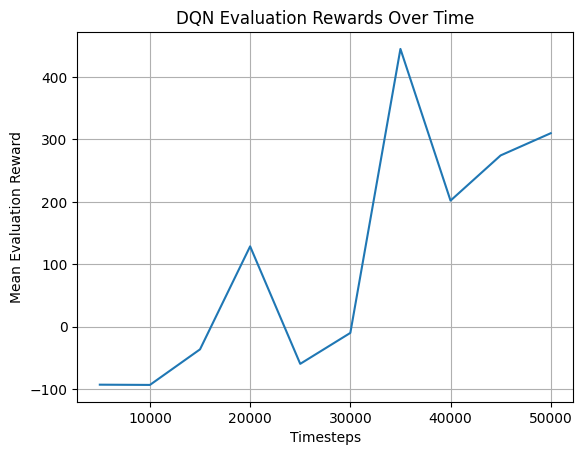

In [2]:

# ------- Training Parameters ---------
timesteps = 50000
learning_rate = 3e-4
buffer_size = 50000
batch_size = 128
gamma = 0.99
learning_starts = 5000
stacked_frames = 4
target_update_interval = 1000
train_freq = 4
gradient_steps = 1

# -------- Rewards --------------------
#The reward is -0.1 every frame and +1000/N for every track tile visited,
# where N is the total number of tiles visited in the track.
# For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

class RewardShapingWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardShapingWrapper, self).__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

      #  if reward < 0:
      #      reward = -1
      #  else:
      #      speed = np.linalg.norm(info.get("velocity", [0, 0]))
      #      reward += 0.1 * speed

      #  reward = np.clip(reward, -1, 1)
        return obs, reward, terminated, truncated, info

# --------- Training Environment ------------------
env = DummyVecEnv([
    lambda: RewardShapingWrapper(Monitor(gym.make("CarRacing-v2", continuous=False, render_mode="None")))
])
env = VecFrameStack(env, n_stack=stacked_frames)
env = VecTransposeImage(env)

# --------- Evaluation Environment for Callback ----
eval_env_callback = DummyVecEnv([
    lambda: RewardShapingWrapper(Monitor(gym.make("CarRacing-v2", continuous=False, render_mode="None")))
])
eval_env_callback = VecFrameStack(eval_env_callback, n_stack=stacked_frames)
eval_env_callback = VecTransposeImage(eval_env_callback)

# --------- Model Training ------------------------
model = DQN("CnnPolicy", env,
            learning_rate=learning_rate,
            buffer_size=buffer_size,
            batch_size=batch_size,
            learning_starts=learning_starts,
            gamma=gamma,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.05,
            exploration_fraction=0.1, # decay over first 10% of timesteps
            target_update_interval=target_update_interval,
            train_freq=train_freq,
            gradient_steps=gradient_steps,
            verbose=2)

# ---------- EvalCallback Setup -------------------
os.makedirs("./logs/", exist_ok=True)

eval_callback = EvalCallback(
    eval_env_callback,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=5000,
    n_eval_episodes=3,
    deterministic=True,
    render=False
)

model.learn(total_timesteps=timesteps, callback=eval_callback)
model.save("dqn_carracing")

# ----------- Evaluation (Video Generation) --------
eval_env = DummyVecEnv([
    lambda: Monitor(gym.make("CarRacing-v2", continuous=False, render_mode="rgb_array"))
])
eval_env = VecFrameStack(eval_env, n_stack=stacked_frames)
eval_env = VecTransposeImage(eval_env)

obs = eval_env.reset()
done = False
frames = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    frame = eval_env.render()
    frames.append(frame)

eval_env.close()

# ------------ Plot Evaluation Rewards --------------
try:
    data = np.load("./logs/evaluations.npz")
    timesteps_logged = data["timesteps"]
    mean_rewards = data["results"].mean(axis=1)

    plt.plot(timesteps_logged, mean_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Evaluation Reward")
    plt.title("DQN Evaluation Rewards Over Time")
    plt.grid()
    plt.show()
except Exception as e:
    print("Plotting failed:", e)

# --------------- Save Video ------------------------
video_path = "/content/dqn_carracing.mp4"
imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)

## 2. Test model on Montmeló Circuit

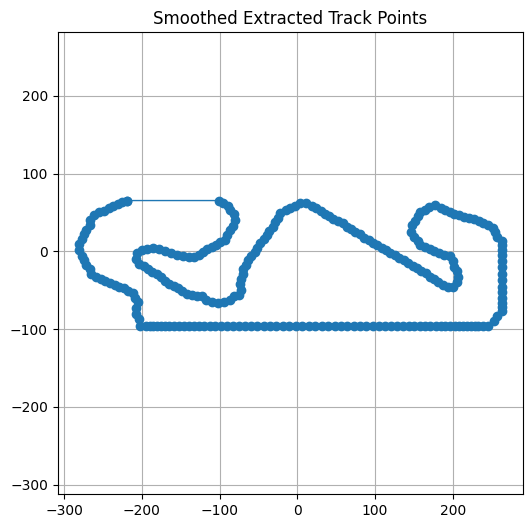

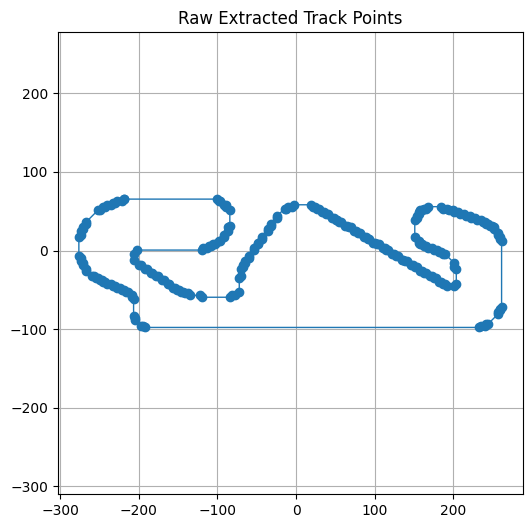

In [ ]:
# create circuit

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import pickle


# Load your image (grayscale)
image_path = "montmelo.png"  # png file
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Invert and threshold to isolate the track shape
_, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Use the largest contour
track_contour = max(contours, key=cv2.contourArea).squeeze()

# Downsample the contour to reduce complexity
track_contour = track_contour[::1]  # take every th point

# Convert to float and center it around (0, 0)
track_contour = track_contour.astype(np.float32)
track_contour -= track_contour.mean(axis=0)

# Rescale
contour_scaler = 1.2 # MAX 1.2 !!
track_contour /= (0.5/contour_scaler)

# Invert Y-axis
track_contour[:, 1] *= -1  # flip y values

# -------- smoothed -----------------------------------------
from scipy.interpolate import splprep, splev

x, y = track_contour[:, 0], track_contour[:, 1]
tck, u = splprep([x, y], s=0.01)
unew = np.linspace(0, 1.0, len(x))
x_smooth, y_smooth = splev(unew, tck)
track_contour2 = np.stack([x_smooth, y_smooth], axis=1).astype(np.float32)

# Ensure closed loop
if not np.array_equal(track_contour2[0], track_contour2[-1]):
    track_contour2 = np.vstack([track_contour2, track_contour2[0]])

# Fix horizontal straight (bottom)
lowest_y = np.percentile(track_contour2[:, 1], 25)
horizontal_straight_idx = np.where(track_contour2[:, 1] < lowest_y + 1.0)[0]
flat_y = -80 * contour_scaler
track_contour2[horizontal_straight_idx, 1] = flat_y

# Fix vertical straight (right)
rightmost_x = np.percentile(track_contour2[:, 0], 95)
vertical_straight_idx = np.where(track_contour2[:, 0] > rightmost_x - 1.0)[0]
flat_x = np.median(track_contour2[vertical_straight_idx, 0])
flat_x = 219 * contour_scaler
track_contour2[vertical_straight_idx, 0] = flat_x

# ------  raw points -----------------------------------------
if not np.array_equal(track_contour[0], track_contour[-1]):
    track_contour = np.vstack([track_contour, track_contour[0]])

# check type
track_contour = track_contour.astype(np.float32)
# ------------------------------------------------------------

# Plot the smoothed points
plt.figure(figsize=(6, 6))
plt.plot(track_contour2[:, 0], track_contour2[:, 1], marker='o', linewidth=1)
plt.title("Smoothed Extracted Track Points")
plt.axis("equal")
plt.grid(True)
plt.show()

# Plot the raw points
plt.figure(figsize=(6, 6))
plt.plot(track_contour[:, 0], track_contour[:, 1], marker='o', linewidth=1)
plt.title("Raw Extracted Track Points")
plt.axis("equal")
plt.grid(True)
plt.show()





# create track points from a track_contour

##############################
track_contour = track_contour2 # For smoothed version, otherwise comment
##############################

track_points = []
for i in range(len(track_contour)):
    x1, y1 = map(float, track_contour[i])
    x2, y2 = map(float, track_contour[(i + 1) % len(track_contour)])

    tangent = np.arctan2(y2 - y1, x2 - x1)
    # Compute normal directions
    n1 = tangent + np.pi / 2
    n2 = tangent - np.pi / 2
    # Choose outward-pointing normal
    dot1 = x1 * np.cos(n1) + y1 * np.sin(n1)
    beta = n1 if dot1 > 0 else n2

    alpha = np.arctan2(y1, x1)
    track_points.append((alpha, beta, x1, y1))

assert all(isinstance(x, float) for point in track_points for x in point)


# save points
TRACK_POINTS = track_points
with open("montmelo_track.pkl", "wb") as f:
    pickle.dump(track_points, f)

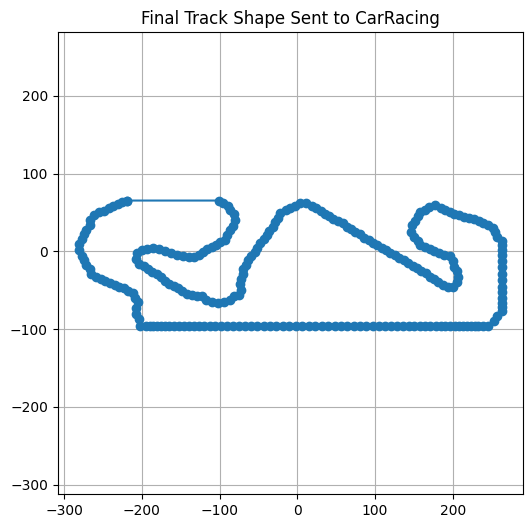

In [ ]:
# Custom Gymnasium environment with fixed track
import gymnasium as gym
from gymnasium.envs.box2d import CarRacing
from gymnasium.envs.registration import register
import numpy as np
from stable_baselines3 import SAC
from Box2D.b2 import fixtureDef, polygonShape
import math


# Load TRACK_POINTS
with open("montmelo_track.pkl", "rb") as f:
    TRACK_POINTS = pickle.load(f)


# Convert TRACK_POINTS to (alpha, beta, x, y)

track = [(alpha, beta, x, y) for (alpha, beta, x, y) in TRACK_POINTS]


import matplotlib.pyplot as plt

# Unpack and plot the shape from `track`
xs = [x for _, _, x, y in track]
ys = [y for _, _, x, y in track]

plt.figure(figsize=(6, 6))
plt.plot(xs, ys, marker='o')
plt.title("Final Track Shape Sent to CarRacing")
plt.axis("equal")
plt.grid(True)
plt.show()
#-------------------------------------



In [ ]:
# ---------- Custom subclass ----------
class MontmeloCarRacing(CarRacing):
    def _create_track(self, debug=False):
        TRACK_WIDTH = 8.0
        BORDER = 0.5

        self.road = []
        self.road_poly = []
        self.track = track

        if debug:
            print(f"Track has {len(self.track)} points")
            for i in range(min(5, len(self.track))):
                print(f"  {self.track[i]}")

        for i in range(len(self.track)):
            alpha1, beta1, x1, y1 = self.track[i]
            alpha2, beta2, x2, y2 = self.track[(i + 1) % len(self.track)]

            road1_l = (x1 - TRACK_WIDTH * np.cos(beta1), y1 - TRACK_WIDTH * np.sin(beta1))
            road1_r = (x1 + TRACK_WIDTH * np.cos(beta1), y1 + TRACK_WIDTH * np.sin(beta1))
            road2_l = (x2 - TRACK_WIDTH * np.cos(beta2), y2 - TRACK_WIDTH * np.sin(beta2))
            road2_r = (x2 + TRACK_WIDTH * np.cos(beta2), y2 + TRACK_WIDTH * np.sin(beta2))

            vertices = [road1_l, road1_r, road2_r, road2_l]

            if any(np.isnan(coord) for v in vertices for coord in v):
                if debug:
                    print(f"Skipping invalid tile at index {i}: {vertices}")
                continue

            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            t.color = self.road_color
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road.append(t)
            self.road_poly.append((vertices, t.color))

        return True

# ---------- Register your custom environment ----------
register(
    id="MontmeloCarRacing-v0",
    entry_point="__main__:MontmeloCarRacing",
)

# ---------- Load the trained DQN model ----------
model = DQN.load("dqn_carracing")  # path to your saved DQN model

# ---------- Create the evaluation environment ----------
env = DummyVecEnv([
    lambda: gym.make("MontmeloCarRacing-v0", continuous=False, render_mode="rgb_array")
])
env = VecFrameStack(env, n_stack=stacked_frames)
env = VecTransposeImage(env)

# ---------- Run the evaluation episode ----------
obs = env.reset()
done = False
frames = []

max_frames = 300  # limit duration
frame_count = 0

while not done and frame_count < max_frames:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    frame_count += 1

env.close()

# ---------- Save the video ----------
video_path = "/content/dqn_montmelo.mp4"
imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)

print(f"Video saved to {video_path}")


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment MontmeloCarRacing-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.06GB > 7.53GB
  warnings.warn(


Video saved to /content/dqn_montmelo.mp4


In [ ]:
# Step 6: Download the video
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>